# Molecular Fingerprints

Las moléculas pueden ser representadas de diversas maneras. En este tutorial veremos un tipo de representación llamada "Molecular Fingerprint". Es una representanción muy simple pero que funciona muy bien para moleculas con similaridad a fármacos pequeñas

In [1]:
import deepchem as dc
dc.__version__

Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (C:\Users\alloh\Miniconda3\lib\site-packages\deepchem\models\torch_models\__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'pytorch_lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


'2.7.1'

## Que es Fingerprint?

Los modelos de DL casi siempre usan un array de números como entradas. Si queremos procesar moléculas en ellos, de alguna manera tenemos que representar cada molécula como un array de números.

Algunos modelos usan arrays de tamaño fijo. Esto es un reto en las moléculas debido a sus diferentes números de átomos.

Los **Fingerprints** estan diseñados para solucionar este problema. Son **arrays** fijos donde los **diferentes elementos** indican la **presencia de diferentes características** en la molécula. Si dos moléculas tienen un fingerprint similar, indica que contienen el mismo tipo de características y por lo tanto tienen similaridad quimica

Para hacer uso de **Fingerprints en DeepChem** tenemos los "Extended Connectivity Fingerprint" o **"ECFP"**. Tambien se les llama a veces "circular Fingerprints". El **algoritmo ECFP** comienza **clasificando los átomos** basandose solo en sus **propiedades directas y enlaces.** Por ejemplo, un carbono unido a dos hidrogenos y dos átomos pesados sería una característica (feature). **Ira identificando las nuevas estructuras mediante niveles de características (en circulos).** Esto se realiza un número fijo de iteraciones y cada **círculo será una columna en nuestro array** y **las filas representaran en número de características en ese círculo.** Se ve muy bien en la imagen de abajo

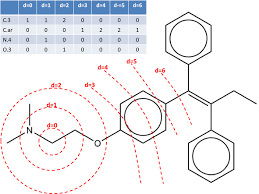

Veamos un dataset que ha sido featurizado con ECFP

In [102]:
tasks, datasets, transformers = dc.molnet.load_tox21(featurizer='ECFP')
train_dataset, valid_dataset, test_dataset = datasets
print(train_dataset)

<DiskDataset X.shape: (6264, 1024), y.shape: (6264, 12), w.shape: (6264, 12), task_names: ['NR-AR' 'NR-AR-LBD' 'NR-AhR' ... 'SR-HSE' 'SR-MMP' 'SR-p53']>


Podemos ver como tiene un **shape de X de (6264, 1024)**. Esto quiere decir que hay **6264 muestras** en el conjunto de entrenamiento. Cada una representada por un **fingerprint de 1024** (tamaño fijo). Tambien fijarnos que el **array y tiene (6264, 12)**, por lo que es un **dataset multitarea. 12 propiedades fueron usadas para la toxicidad de las moléculas.**

In [3]:
train_dataset.w

array([[1.04502242, 1.03632599, 1.12502653, ..., 1.05576503, 1.17464996,
        1.05288369],
       [1.04502242, 1.03632599, 1.12502653, ..., 1.05576503, 1.17464996,
        1.05288369],
       [1.04502242, 1.03632599, 1.12502653, ..., 1.05576503, 0.        ,
        1.05288369],
       ...,
       [1.04502242, 0.        , 1.12502653, ..., 1.05576503, 6.7257384 ,
        1.05288369],
       [1.04502242, 1.03632599, 1.12502653, ..., 1.05576503, 6.7257384 ,
        1.05288369],
       [1.04502242, 1.03632599, 1.12502653, ..., 0.        , 1.17464996,
        1.05288369]])

Nos podemos fijar que algunos pesos tienen un valor 0. Esto se usa para representar los missing values (ya que un peso de 0 hace que el algoritmo lo ignore).

La mayoría de los otros pesos tienen valores cercanos a 1, pero no exactamente 1. Esto se realiza con el propósito de equilibrar el peso global de las muestras positivas y negativas en cada tarea. Durante el entrenamiento del modelo, se busca que cada una de las 12 tareas contribuya de manera equitativa, y en cada tarea se asigna igual importancia a las muestras positivas y negativas. De lo contrario, el modelo podría aprender que la mayoría de las muestras de entrenamiento son no tóxicas y, por lo tanto, sesgar sus predicciones hacia la clasificación de otras moléculas como no tóxicas.


## Entrenamiento de un modelo con Fingerprints

Vamos a entrenar un MultitaskClassifier que es una simple pila de capas conectadas entre si. En este ejemplo usaremos una única capa oculta de tamaño 1000. Tambien le indicamos que el input tendrá 1024 características y que debe producir 12 predicciones para las diferentes tareas.

Podriamos entrenar un modelo para cada tarea, pero normalmente da mejores resultados entrenar un modelo único.

In [99]:
model = dc.models.MultitaskClassifier(n_tasks=12, n_features=1024, layer_sizes=[1000])

Entrenaremos y evaluaremos el modelo:

In [46]:
import numpy as np

model.fit(train_dataset, nb_epoch=10)
metric = dc.metrics.Metric(dc.metrics.roc_auc_score)
print('training set score:', model.evaluate(train_dataset, [metric], transformers))
print('test set score:', model.evaluate(test_dataset, [metric], transformers))

training set score: {'roc_auc_score': 0.9578216192603528}
test set score: {'roc_auc_score': 0.6841718576680565}


Obtenemos un rendimiento decente teniendo en cuenta que tenemos un modelo y una featurizacion bastante simple

**NOTA:** el ROC/AUC es una métrica que evalúa la capacidad de un modelo de clasificación para discriminar entre clases positivas y negativas y se utiliza para comparar el rendimiento de diferentes modelos en problemas de clasificación binaria. Un valor más alto de ROC AUC generalmente indica un mejor rendimiento del modelo.